## **Word Prediction in a Mobile Device Federation**

## **Business Understanding**

## **Business Objectives**
When a user is typing text on a mobile device it can be useful to suggest the next word as this will optimize typing time and also avoid possible errors. However, this data has private information, which limits its movement to a centralized environment. In this paper we will demonstrate how to predict the next word while guaranteeing users privacy without moving the data around.

<!-- Quando um usuario esta digitando um texto num dispositivo móvel pode ser útil sugerir a próxima palavra pois isso otimizará o tempo de digitação e ainda evitará possíveis erros. Contudo, estes dados possuem informações privadas o que limita a movimentação destes para um ambiente centralizado.
Neste trabalho será demonstrado como realizar a predição da próxima palavra garantindo a privacidade dos usuários sem a necessidade de movimentar os dados. -->


### **Data Mining Goals**
This work has how goals to predict the next word, ensuring data privacy. Sheakpeare pieces will be used as input data. These will be obtained, described, pre-processed and explored for a better understanding. Next, the federation environment will be created where each character in Sheakpeare's works will be a participating user, and their speeches will be the input dataset in the prediction model. From this scenario, in which data is only found on mobile devices, Federated Learning will be used to perform the model training in a shared way without moving the data to a centralized environment. For this, steps will be carried out to load a pre-trained global model from a central server, data pre-processing and model training on the user's own device. Then the model parameters will be forwarded to the central server to update the federated average and train the global model.

<!-- Este trabalho tem como objetivo fazer a predição da próxima palavra garantindo a privacidade dos dados. Será utilizado as peças de Sheakpeare como dados de entrada. Estes serão obtidos, descritos, preprocessados e explorados para uma melhor compreensão. Em seguida será criado o ambiente de federação onde cada personagem das obras do Sheakpeare será um usuário participante sendo que as falas destes serão o dataset de entrada no modelo de predição. A partir deste cenário, o qual os dados se encontram somente nos dispositivos móveis, será utilizado Federated Learning para realizar o treinamento do modelo de modo compartilhado sem movimentar os dados para um ambiente centralizado. Para isso serão realizadas etapas de carregamento de um modelo global pré-treinado a partir de um servidor central, preprocessamento dos dados e treinamento do modelo no próprio dispositivo do usuário. Em seguida os parâmetros do modelo serão encaminhados para o servidor central para atualizar a média federada e treinar o modelo global.   -->

## Project Plan
1. Get the data
2. Data Describe 
3. Preprocessing 
4. Data exploration
5. Create tensors. `NOTE: From this point on, the data is in the same pattern as the tff simulation module`
7. Data Federated Understanding
8. Load the Federated Data. `NOTE: now on the next steps will be done on a federation client`
10. Preprocess the Data 
11. Load pre-trained model each client
12. Compile the model and test on the preprocessed data
13. Fine-tune the model with Federated Learning

## **Prepare Environment**

<br/>

### Imports

In [166]:
# data analysis and data wrangling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
from PIL import Image

from plotly.offline import plot, iplot
import plotly.graph_objs as go # create graphics
import plotly.offline as py
import plotly

import cufflinks as cf # conect ploty and pandas
import plotly.io as pio

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import pyLDAvis.sklearn

# ml and dl
# import tensorflow_federated as tff
import tensorflow as tf
import nest_asyncio

## Natural Processing Language
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk

# other
from imp import reload

# import platform
import warnings
import platform
import pathlib
import pprint
import string
import json
import time
import re
import os

<br/>

### Prepare Work Directory 

In [ ]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}

In [ ]:
path_to_work('notebooks')

<br/>

### Set Config

In [168]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500, 
    'figure.autolayout': True, 
    'figure.figsize': [17, 12], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 10, 
    'lines.linewidth': 1.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 15,
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

nest_asyncio.apply()

#### Set Ploty

In [169]:
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
pio.renderers
pio.renderers.default = 'jupyterlab'

<br/>

### Show Configurations

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

---

## **Data Understanding**

### **Collect Initial Data**
- The data consists in Shakespeare’s plays.
- Hosted in [Project Gutenberg](https://www.gutenberg.org/).

In [172]:
%%time

!bash src/download_dataset.sh \
    -u http://www.gutenberg.org/files/100/old/1994-01-100.zip \
    -p data/raw

----------------------------------------
----------- Downloading data -----------
----------------------------------------
--2021-12-11 15:59:59--  http://www.gutenberg.org/files/100/old/1994-01-100.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 2610:28:3090:3000:0:bad:cafe:47, 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|2610:28:3090:3000:0:bad:cafe:47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gutenberg.org/files/100/old/1994-01-100.zip [following]
--2021-12-11 15:59:59--  https://www.gutenberg.org/files/100/old/1994-01-100.zip
Connecting to www.gutenberg.org (www.gutenberg.org)|2610:28:3090:3000:0:bad:cafe:47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2035857 (1,9M) [application/zip]
Saving to: ‘data/raw/temp_file.zip’

data/raw/temp_file. 100%[===================>]   1,94M  1,60MB/s    in 1,2s    

2021-12-11 16:00:01 (1,60 MB/s) - ‘data/raw/temp_file.zip’ saved [2035857/20358

In [173]:
%%time

raw_data = open('data/raw/100.txt', mode='r').read()

CPU times: user 20.7 ms, sys: 4.01 ms, total: 24.7 ms
Wall time: 21.7 ms


<br/>

### **Describe Data**


In [174]:
count_rows = raw_data.count('\n')
unique_char = sorted(set(raw_data))
list_words_tokens = word_tokenize(raw_data)

In [175]:
print(f'Total rows: {count_rows}')
print(f'Total tokens: {len(list_words_tokens)}')
print(f'Total characters: {len(raw_data)}')
print(f'Total unique character: {len(unique_char)}')
print(f'\nSample:\n{raw_data[:500]}')

Total rows: 124788
Total tokens: 1134708
Total characters: 5465129
Total unique character: 91

Sample:
The Project Gutenberg EBook of The Complete Works of William Shakespeare, by
William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org

** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **
**     Please follow the copyright guidelines in this file.     **

Title: The Comple


### The unique characters in the file

In [176]:
print('characters:\n', unique_char)

characters:
 ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '~']


### Dataset General Information
- The data set is in text format
- It has 
  - Total rows: 124788
  - Total tokens: 1134708
  - Total characters: 5465129
  - Total unique character: 91

---

## **Preprocessing**

In [177]:
def remove_unnecessary_text(str_shakespeare_full: str, int_last_line: int):
    """
    Remove:
        -> the first lines
        -> the last lines
        -> the poems
        -> This piece:
            '<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM
                SHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS
                PROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE
                WITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE
                DISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS
                PERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED
                COMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY
                SERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>'
    """    
    str_pre_clean = re.sub("<(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)\n(.+)",
                           '',
                           str_shakespeare_full)
    
    slines = str_pre_clean.splitlines(keepends=True)[1:int_last_line]
    author_count = 0
    start_line = 1
    
    for i, row in enumerate(slines):        
        # under the title always appears "by William Shakespeare"
        if 'by William Shakespeare' in row: 
            author_count += 1
        
        # position where the first play starts
        if author_count == 2:
            start_line = i - 5
            break
    
    return slines[(start_line + 2):]

In [178]:
data_pre_cleansing = remove_unnecessary_text(str_shakespeare_full=raw_data,
                                             int_last_line=122343)
data_pre_cleansing[1300]

'    Which, as your due, time claims, he does acknowledge;\n'

In [179]:
data_cleansing = [x.lstrip() for x in data_pre_cleansing]
data_cleansing[1300]

'Which, as your due, time claims, he does acknowledge;\n'

#### Save text with new formatting

In [180]:
data_cleansing_txt = " ".join(str(x) for x in data_cleansing)

with open('data/cleansing/data_preprocess.txt', mode='w') as w:
    w.write(str(data_cleansing_txt))

### Create a mapping from unique characters to indices

In [181]:
char2idx = {u:i for i, u in enumerate(unique_char)}
idx2char = np.array(unique_char)

### Bag-of-Words
- A bag-of-words is a representation of text that describes the occurrence of words within a document. 
- It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. 

In [182]:
def create_bag_of_words(list_words: list, ngram: int) -> list:
    vec = CountVectorizer(ngram_range=(ngram, ngram),
                          stop_words="english",
                          lowercase=True)
    
    bag_of_words = vec.fit_transform(list_words)
    sum_words = bag_of_words.sum(axis=0)

    return [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

### TF-IDF
Reflect how important a word is to a document in a collection or corpus

In [183]:
def tfidf_vectorizer(documents, total_features: int):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                       min_df=2,
                                       max_features=total_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    return tfidf_vectorizer, tfidf, tfidf_feature_names

def count_vectorizer(documents, total_features: int):
    tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=2,
                                    max_features=total_features,
                                    stop_words='english')
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()
    return tf_vectorizer, tf, tf_feature_names

In [184]:
total_features = 100000
no_top_words = 20

In [185]:
tfidf_vectorizer, tfidf, tfidf_feature_names = tfidf_vectorizer(data_cleansing,
                                                                total_features)
tf_vectorizer, tf, tf_feature_names = count_vectorizer(data_cleansing, 
                                                       total_features)

---

## **Explore Data**


In [186]:
bag_of_words = create_bag_of_words(list_words=data_cleansing, ngram=1)

In [187]:
def get_top_n_words(bag_of_words, n_elements) -> list:
    return sorted(bag_of_words, key = lambda x: x[1], reverse=True)[:n_elements]

In [188]:
top_20_words = get_top_n_words(bag_of_words, 20)
df_unigram = pd.DataFrame(top_20_words, columns = ['word' , 'count'])
df_unigram.head()

,word,count
0,thou,5307
1,thy,3745
2,shall,3538
3,lord,3093
4,king,3039


#### The distribution of top unigrams after removing stop words

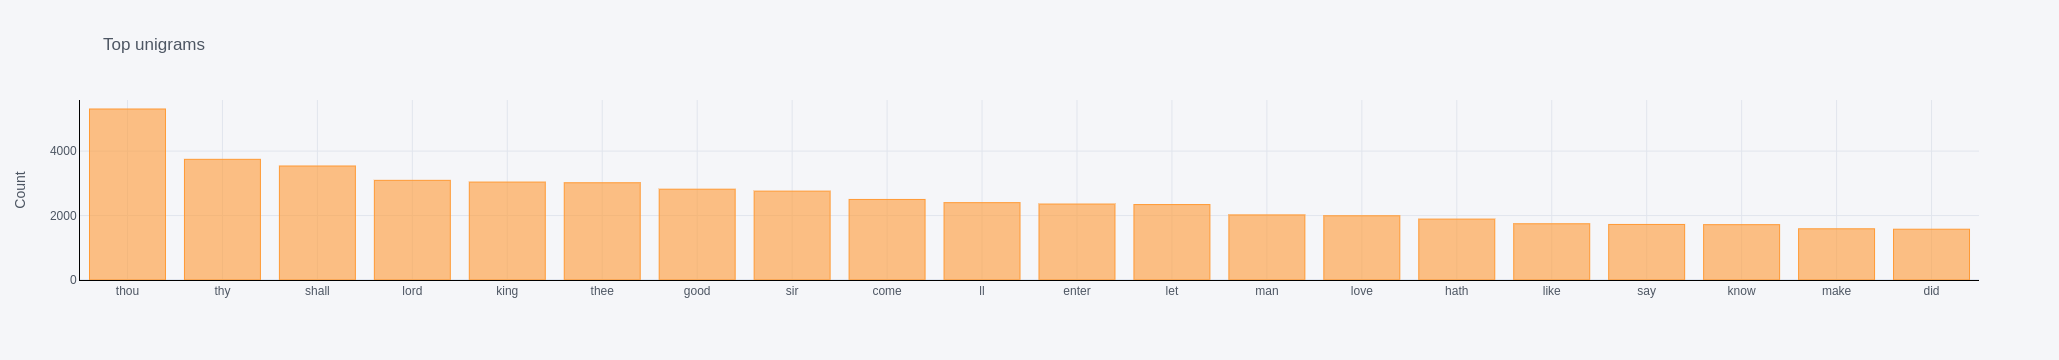

In [189]:
df_unigram\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='Top unigrams')

In [190]:
# ploty -> static image
# display(Image.open('reports/unigram.png'))

<br/>

#### The distribution of top bigrams after removing stop words

In [191]:
bag_of_words_bigram = create_bag_of_words(data_cleansing, ngram=2)

In [192]:
top_20_words_bigram = get_top_n_words(bag_of_words_bigram, 20)
df_bigram = pd.DataFrame(top_20_words_bigram, columns = ['word' , 'count'])
df_bigram.head()

,word,count
0,thou art,501
1,king henry,399
2,thou hast,354
3,king richard,277
4,st thou,249


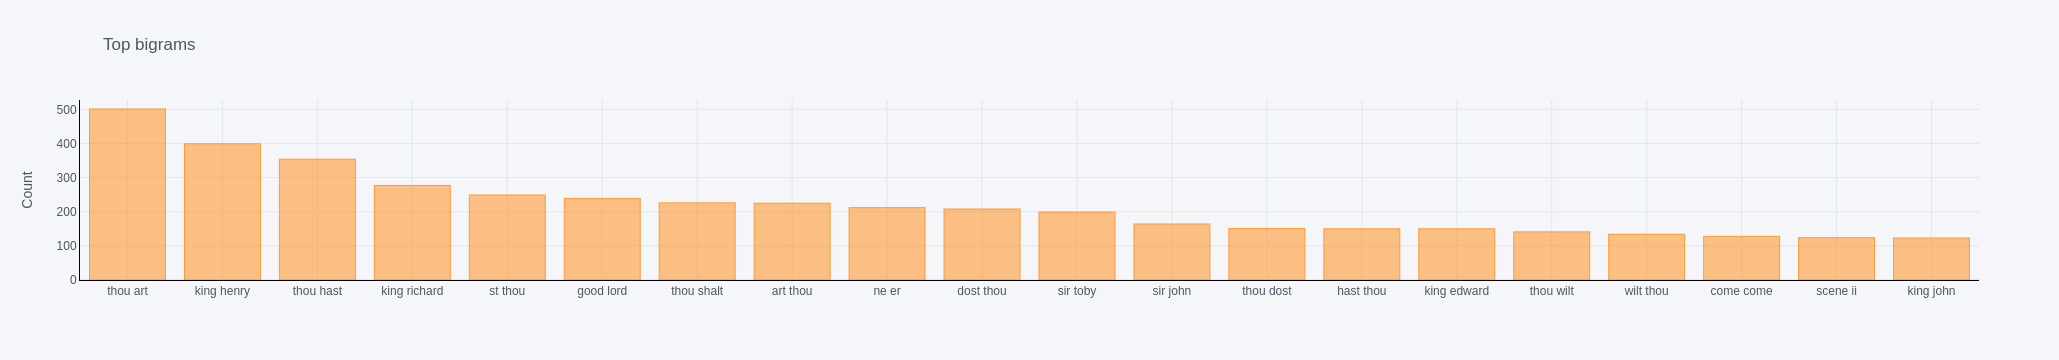

In [193]:
df_bigram\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='Top bigrams')

In [194]:
# ploty -> static image
# display(Image.open('reports/bigram.png'))

<br/>

#### Top unigrams to Romeo and Juliet User

In [195]:
THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM = open('data/'\
                                           'federation/'\
                                           'users_split_by_pearsons/'\
                                           'THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM.txt', mode='r')

In [196]:
bag_of_words = create_bag_of_words(list_words=THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM, ngram=1)
top_20_words = get_top_n_words(bag_of_words, 20)
df_unigram_romeo = pd.DataFrame(top_20_words, columns = ['word' , 'count'])

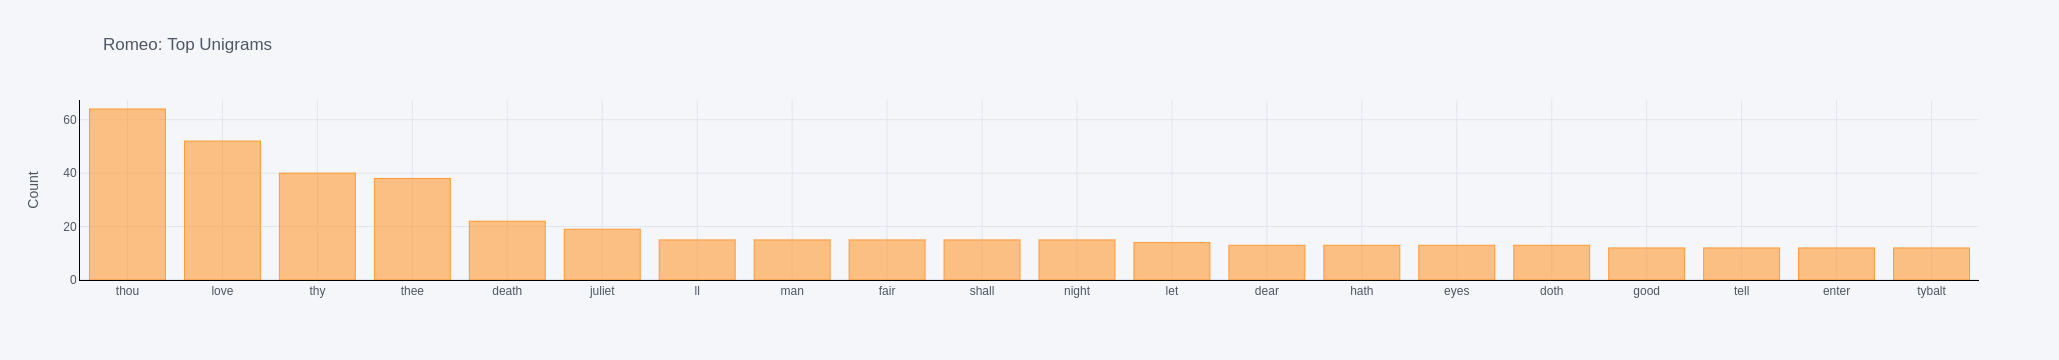

In [197]:
df_unigram_romeo\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='Romeo: Top Unigrams')

In [198]:
THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL = open('data/'\
                                           'federation/'\
                                           'users_split_by_pearsons/'\
                                           'THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL.txt', mode='r')

In [199]:
bag_of_words = create_bag_of_words(list_words=THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL, ngram=1)
top_20_words = get_top_n_words(bag_of_words, 20)
df_unigram_juliet = pd.DataFrame(top_20_words, columns = ['word' , 'count'])

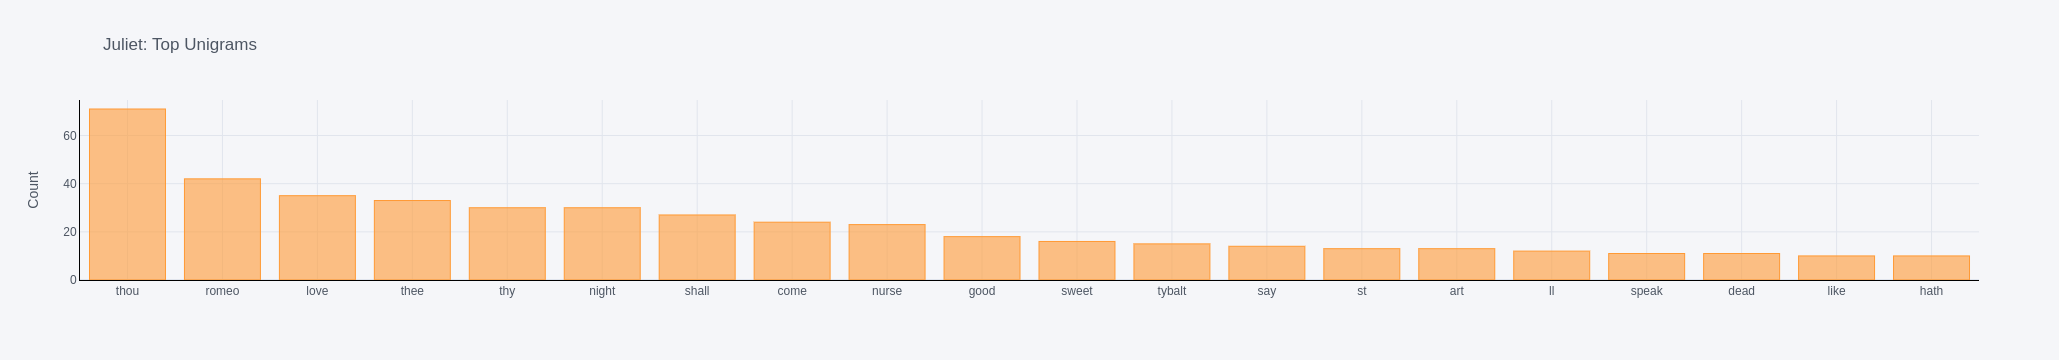

In [200]:
df_unigram_juliet\
  .groupby('word')\
  .sum()['count']\
  .sort_values(ascending=False)\
  .iplot(kind='bar',
         yTitle='Count',
         linecolor='black',
         title='Juliet: Top Unigrams')

### Latent Dirichlet Allocation (LDA) 
Latent Dirichlet allocation (LDA) is a technique that automatically discovers topics that these documents contain

#### For example
if you know you have a topic about **Apple** products it can be helpful to bias words like **iphone** and **ipad** for one of the topics in order to push the model towards finding that particular topic.

<!-- projetada para auxiliar na modelagem de dados que consistem em um grande corpus de palavras.
O LDA é baseado em duas suposições gerais:
- Documentos que têm palavras semelhantes geralmente têm o mesmo tópico
- Documentos que têm grupos de palavras que ocorrem frequentemente juntas geralmente têm o mesmo tópico.


O raciocínio é:
- Documentos são distribuições de probabilidade sobre tópicos latentes
- Tópicos são distribuições de probabilidade sobre palavras
 -->


In [201]:
%%time

model_lda = LatentDirichletAllocation(max_iter=100,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0).fit(tfidf)

model_lda

CPU times: user 23min 1s, sys: 790 ms, total: 23min 2s
Wall time: 23min 6s


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=100, random_state=0)

In [202]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic:", (topic_idx))
        print(" ".join([feature_names[i]
        
        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [203]:
display_topics(model_lda, tfidf_feature_names, no_top_words)

Topic: 0
scene th hand lord pray son brother eyes leave second old act young end tongue mind follow right england kill
Topic: 1
let king come away grace till bear er richard york france little lords great faith said enter hither swear lord
Topic: 2
enter know speak man tell honour blood better soul marry edward bid ere antonio truth reason cleopatra come lay tears
Topic: 3
exit men doth day poor long farewell heard gentle fellow crown desdemona ring kind ye believe letter prove hot seek
Topic: 4
say exeunt queen like prince fair comes heaven gloucester daughter gentleman mother othello best eye turn forth matter things state
Topic: 5
time love master night fear god caesar shall servant friend page antony timon warwick welcome clown sir hope aside lord
Topic: 6
thou hath duke thee think good st art ay king father thy stand ll henry hast brutus dead gone live
Topic: 7
heart lady hear life true john falstaff bring set hold dear unto words rest messenger sword came home use thy
Topic: 8
sh

### Topic Semantic Analysis
By analyzing the words, topics can be classified:
- Topic 1: Family Duel
- Topic 2: Actions of a king
- Topic 3: Romantic dispute
- Topic 4: Farewell (Despedida)
- Topic 5: Relationship between queen, mother, prince and gentleman

### Display Topic Modelling How Clusters of the Words
- Each bubble represents a topic.
- Blue bars represent the overall frequency of each word in the corpus
<!-- As barras vermelhas fornecem o número estimado de vezes que um determinado termo foi gerado por um determinado tópico. -->
- Red bars give the **estimated number** of times a given term was generated **by a given topic**. 
- The further the bubbles are away from each other, the more different they are

In [204]:
data_op = pyLDAvis.sklearn.prepare(model_lda, 
                                   tfidf,
                                   tfidf_vectorizer)

pyLDAvis.enable_notebook()
pyLDAvis.display(data_op)

**NOTE:**
A good topic model will have big and non-overlapping bubbles scattered throughout the chart. 

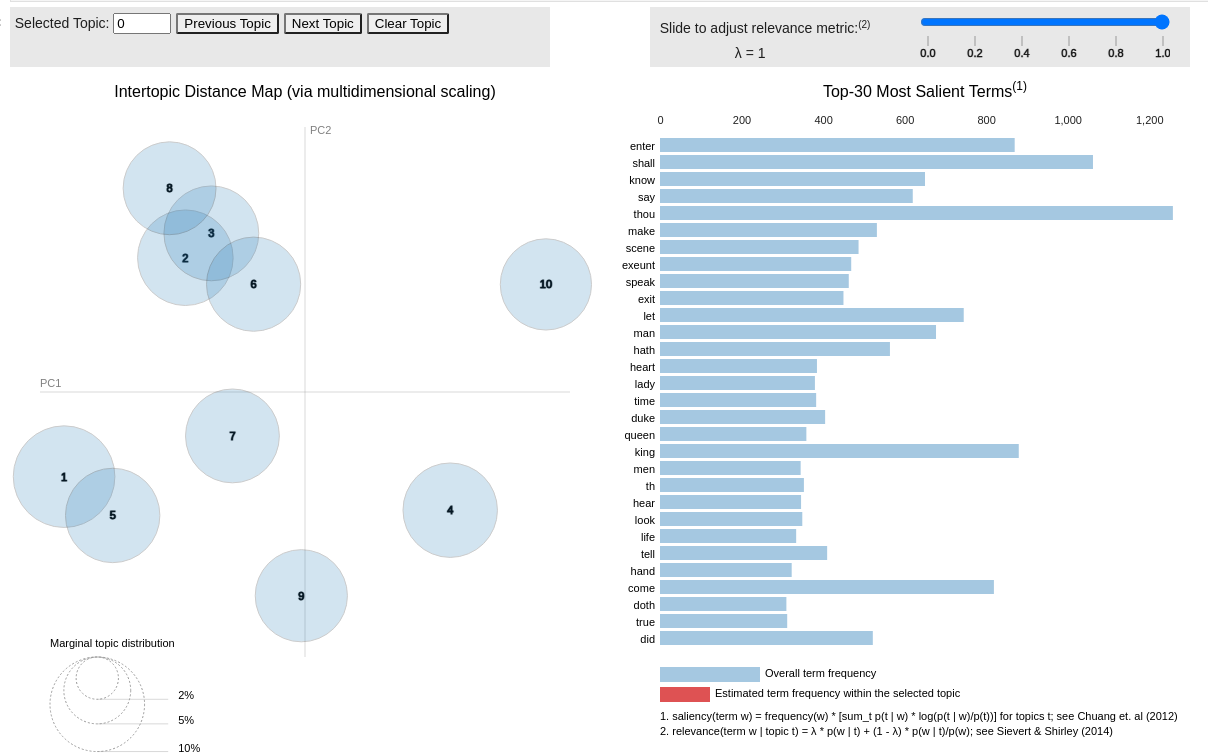

In [205]:
# ploty -> static image
display(Image.open('reports/lda_intertopic.png'))

### Wordcloud

[Text(0.5, 1.0, 'WordCloud')]

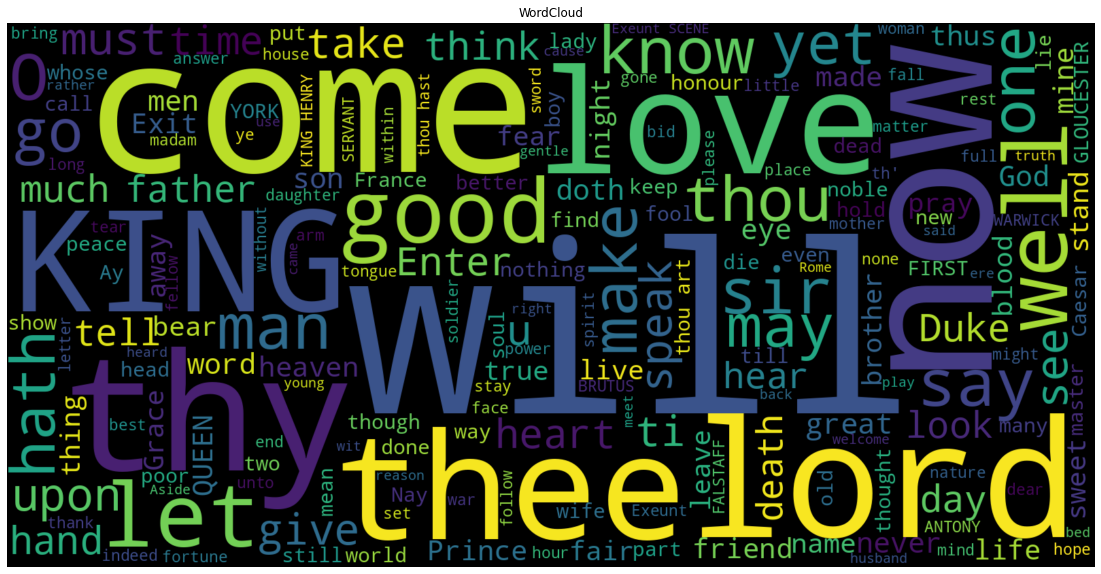

In [206]:
wordcloud = WordCloud(background_color="black",
                      width=1600, 
                      height=800).generate(data_cleansing_txt)

# show
img_wordcloud, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.set(title="WordCloud")

In [207]:
# savefig()

def save_image(img: 'matplotlib',
               name: str,
               path: str = 'reports/'):
    
    fig = img.get_figure()
    fig.savefig(f"reports/{name}.png")
    
    return f"Image {name} saved."

In [208]:
save_image(img=img_wordcloud, name='wordcloud')

'Image wordcloud saved.'

<br/>

#### Romeo: WordCloud

In [209]:
str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM = None
with open('data/'\
          'federation/'\
          'users_split_by_pearsons/'\
          'THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM.txt', mode='r') as rom:
    str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM = rom.read()

[Text(0.5, 1.0, 'Romeo: WordCloud')]

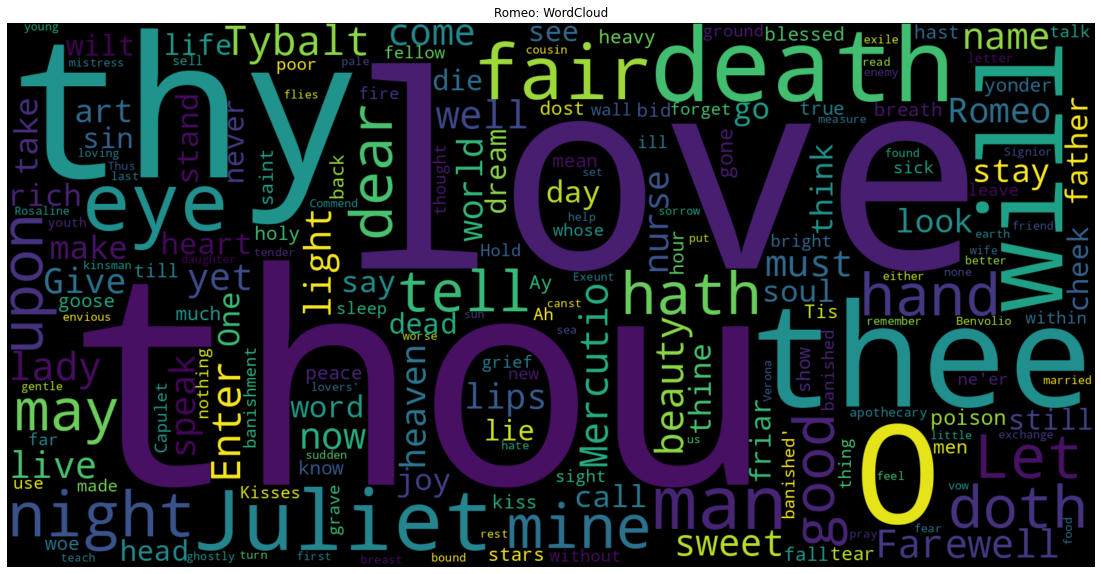

In [210]:
wordcloud = WordCloud(background_color="black",
                      width=1600, 
                      height=800).generate(str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_ROM)

# show
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.set(title="Romeo: WordCloud")

<br/>

#### Juliet: WordCloud

In [211]:
str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL = None
with open('data/'\
          'federation/'\
          'users_split_by_pearsons/'\
          'THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL.txt', mode='r') as rom:
    str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL = rom.read()

[Text(0.5, 1.0, 'Juliet: WordCloud')]

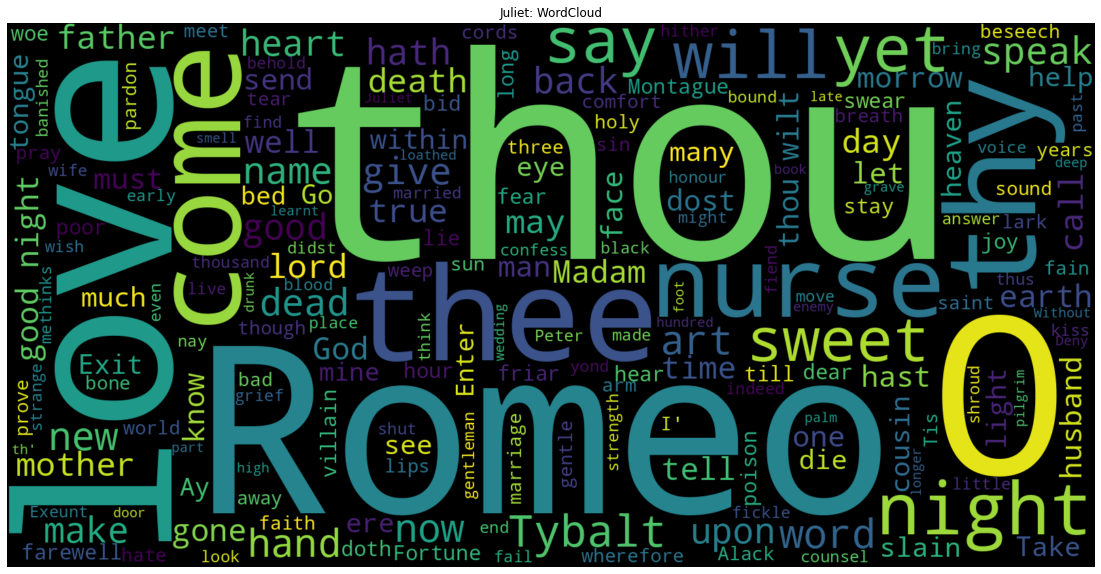

In [213]:
wordcloud = WordCloud(background_color="black",
                      width=1600, 
                      height=800).generate(str_THE_TRAGEDY_OF_ROMEO_AND_JULIET_JUL)

# show
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
ax.set(title="Juliet: WordCloud")

---